**Deskripsi Masalah**

Misalkan Anda telah dipekerjakan oleh Angkatan Laut Bangladesh sebagai analis data untuk kapal selam kelas Ming yang baru mereka peroleh. Mereka berencana menggunakan kapal selam ini untuk mengamankan perbatasan maritim nasional. Salah satu target potensial mereka adalah kapal bajak laut. Mereka menggunakan sonar akustik aktif untuk menemukan kapal yang mengapung. Dengan mengirimkan pulsa suara dan menerima gema pada array, sonar dapat menentukan arah dari gema yang kembali dari objek yang terkena suara tersebut. Mereka juga dapat mengukur waktu yang dibutuhkan oleh gema untuk kembali dan menghitung jarak ke objek yang menyebabkan gema. Sayangnya, jika ada beberapa kapal di sekitar, sinyal-sinyal tersebut dapat menyebabkan interferensi. Dengan menggunakan visual periskop, memungkinkan untuk menentukan jumlah kapal, tetapi lokasi pasti dari setiap kapal sulit ditemukan. Tanpa lokasi yang tepat, tembakan torpedo tidak dapat dijamin mengenai target. Plot 2D dari contoh data sonar diberikan dalam Gambar 1. Ada tiga kapal di permukaan air, masing-masing berada di dalam lingkaran hitam. Setiap titik biru mewakili satu pengukuran lokasi dari salah satu dari tiga kapal tersebut. Anda diminta untuk membangun sistem yang mengambil data sonar serta jumlah kapal sebagai input dan memberikan perkiraan lokasi dari setiap kapal.

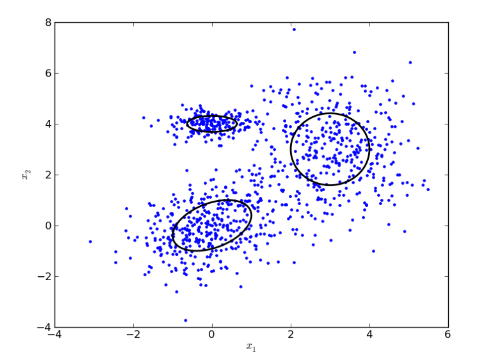


In [ ]:
import numpy as np
import pandas as pd
import random as rand
import matplotlib.pyplot as plt
from scipy.stats import norm
import math as mt

In [ ]:
#same random values for every new execution
rand.seed(42)

#taking 3 clusters
mu1 = [0, 5]
sig1 = [ [2, 0], [0, 3] ]

mu2 = [5, 0]
sig2 = [ [4, 0], [0, 1] ]

mu3 = [5, 5]
sig3 = [ [2, 0], [0, 4] ]

#generating samples
x3, y3 = np.random.multivariate_normal(mu1, sig1, 100).T
x4, y4 = np.random.multivariate_normal(mu2, sig2, 100).T
x5, y5 = np.random.multivariate_normal(mu3, sig3, 100).T

x1 = np.concatenate((x3, x4, x5))
x2 = np.concatenate((y3, y4, y5))
labels = ([1] * 100) + ([2] * 100) + ([3] * 100)

Data dihasilkan dari distribusi Gaussian multivariat dengan parameter rata-rata (mu1, mu2, mu3) dan matriks kovarian (sig1, sig2, sig3) untuk masing-masing kluster. Hasilnya adalah 300 titik data yang terdistribusi dalam tiga kluster.

In [ ]:
#generating data
data = {'x1': x1, 'x2': x2, 'label': labels}
df = pd.DataFrame(data)

Kode tersebut membuat sebuah tabel menggunakan Pandas, di mana data yang berisi koordinat titik-titik (x1, x2) yang dihasilkan secara acak dimasukkan bersama dengan label yang menunjukkan kluster mana titik tersebut termasuk. Data ini disusun dalam sebuah DataFrame yang memiliki tiga kolom: x1, x2, dan label. Kolom x1 dan x2 berisi koordinat titik-titik data, sedangkan kolom label menunjukkan nomor kluster untuk setiap titik data, misalnya 1, 2, atau 3. DataFrame ini memudahkan pengolahan dan analisis lebih lanjut terhadap data yang telah dihasilkan.

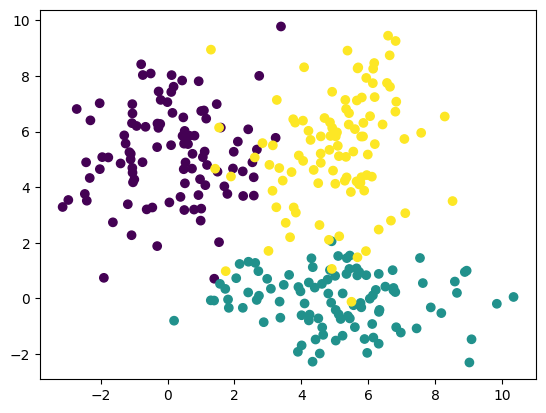

In [ ]:
#showing data pictorially
fig = plt.figure()
plt.scatter(data['x1'], data['x2'], c=data['label'])
fig.savefig("showingData.png")

Data yang dihasilkan divisualisasikan sebagai plot sebar untuk melihat kluster awal.

In [ ]:
#Implementation of Expectation Maximization algorithm


#the probability of generation of x from Gaussian distribution
def prob_N(x, mu, sig, wei):
    pro = wei
    for i in range(len(x)):
        pro *= norm.pdf(x[i], mu[i], sig[i][i])
    return pro

Fungsi prob_N menghitung probabilitas suatu titik x muncul dari distribusi Gaussian dengan parameter tertentu mu, sig, dan wei (bobot). Fungsi ini mengalikan probabilitas pada setiap dimensi (asumsi independen) menggunakan probability density function (pdf) normal.

In [ ]:
#E-Step function
def expectationStep(x, mu, sig, wei):
    pro_clu1 = prob_N(x, mu1, sig1, w[0])
    pro_clu2 = prob_N(x, mu2, sig2, w[1])
    pro_clu3 = prob_N(x, mu3, sig3, w[2])
    p_i_j = prob_N(x, mu, sig, wei) / (pro_clu1 + pro_clu2 + pro_clu3)
    return p_i_j

Pada E-Step, fungsi expectationStep menghitung probabilitas posterior (disebut juga responsibility atau tanggung jawab) bahwa suatu titik data x adalah bagian dari suatu kluster tertentu. Probabilitas ini dihitung dengan membagi probabilitas titik x untuk kluster tersebut dengan total probabilitas dari semua kluster.

In [ ]:
#M-Step function
def MaximizationStep(dataset, mu, sig, wei):
    accProb = 0
    temp = [0, 0]
    temp_sigma = [ [0, 0], [0, 0] ]

    for j in range(dataset.shape[0]):
        x_1 = dataset['x1'][j]
        x_2 = dataset['x2'][j]
        exp = expectationStep([x_1, x_2], mu, sig, wei)
        accProb += exp
        temp1 = exp * np.array([x_1, x_2])
        temp = np.add(temp, temp1)
        temp2 = 1 * np.array([x_1, x_2])
        temp3 = -1 * np.array(mu)
        vect = np.add(temp2,temp3)


        temp_sig = np.multiply(vect, np.transpose(vect))
        temp_sig = exp * temp_sig
        temp_sigma = np.add(temp_sigma, temp_sig)

    temp_mu = (1 /accProb) * temp
    ret_sigma = (1 /accProb) * temp_sigma
    temp_weight = accProb / dataset.shape[0]

    return temp_mu, ret_sigma, temp_weight

M-Step memperbarui parameter rata-rata (mu), kovarian (sig), dan bobot (wei) berdasarkan hasil dari E-Step. Parameter diperbarui sebagai berikut:

1. Rata-rata baru (temp_mu) dihitung sebagai rata-rata berbobot dari titik-titik data.
2. Kovarian baru (temp_sigma) dihitung dengan mengukur dispersi dari setiap titik data terhadap rata-rata baru.
3. Bobot baru (temp_weight) adalah jumlah total dari probabilitas posterior dibagi dengan jumlah total data.

In [ ]:
#get distance between old and new mean to chack convergence
def params_converge(old_params, new_params):
    distance = [0, 0, 0]
    for param in range(3):
        for i in range(2):
            distance[param] += (old_params[param][i] - new_params[param][i]) ** 2
        distance[param] = mt.sqrt(distance[param])
    return distance[0] + distance[1] + distance[2]

Fungsi params_converge menghitung jarak antara parameter rata-rata lama dan yang baru. Ini digunakan sebagai kriteria penghentian iterasi, yaitu ketika jarak ini lebih kecil dari nilai tertentu (di sini, 0.01).

In [ ]:
def logLikelihood(dataset):
    likelihoodProb = 0
    for j in range(dataset.shape[0]):
        x_1 = dataset['x1'][j]
        x_2 = dataset['x2'][j]
        pro_clu1 = prob_N([x_1, x_2], mu1, sig1, w[0])
        pro_clu2 = prob_N([x_1, x_2], mu2, sig2, w[1])
        pro_clu3 = prob_N([x_1, x_2], mu3, sig3, w[2])
        lnProb = mt.log((pro_clu1 + pro_clu2 + pro_clu3), 2)
        likelihoodProb += lnProb

    return likelihoodProb

Fungsi ini menghitung log likelihood dari seluruh dataset berdasarkan parameter model saat ini. Log likelihood adalah ukuran kesesuaian model terhadap data.

Nilai log likelihood digunakan untuk memonitor peningkatan model setiap iterasi dan memastikan bahwa algoritma tidak mengalami divergensi.

initial likelihood -3418.4627415628224
2399.31451592583
1
  
-2399.31451592583 [ 3.26387522 -0.08351779] [[8.28978875 2.55478699]
 [8.28978875 2.55478699]] [5.47124742 3.66138368] [[4.66445751 8.5545989 ]
 [4.66445751 8.5545989 ]] [-0.04693865  5.49118487] [[1.89627958 2.44424221]
 [1.89627958 2.44424221]] 4.512943555650926


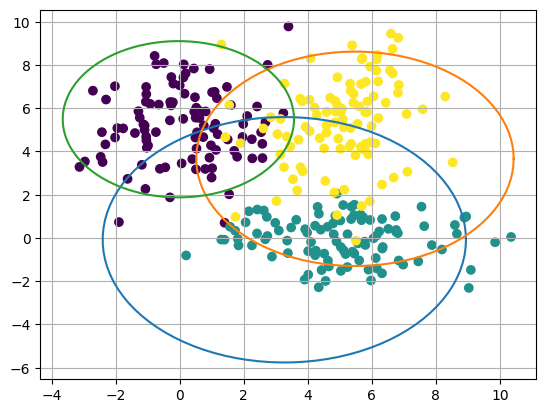

2427.0058687305896
2
  
-2427.0058687305896 [4.67589369 0.71506664] [[7.58901181 4.03406813]
 [7.58901181 4.03406813]] [4.85202578 3.40983231] [[ 4.73560751 10.27278581]
 [ 4.73560751 10.27278581]] [0.65395123 5.10796115] [[4.12183232 3.3086805 ]
 [4.12183232 3.3086805 ]] 3.0893824644049115


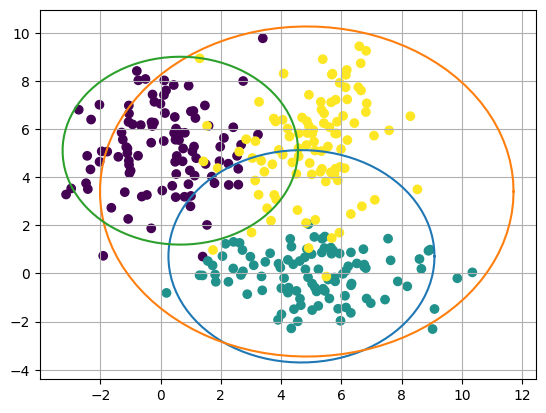

2680.3747972886977
3
  
-2680.3747972886977 [4.34840221 1.79487633] [[7.46051421 8.4119539 ]
 [7.46051421 8.4119539 ]] [4.3708154 2.9620093] [[ 6.5977783  10.65115974]
 [ 6.5977783  10.65115974]] [2.31978457 4.52268607] [[10.44397467  6.29621333]
 [10.44397467  6.29621333]] 3.5513869414929546


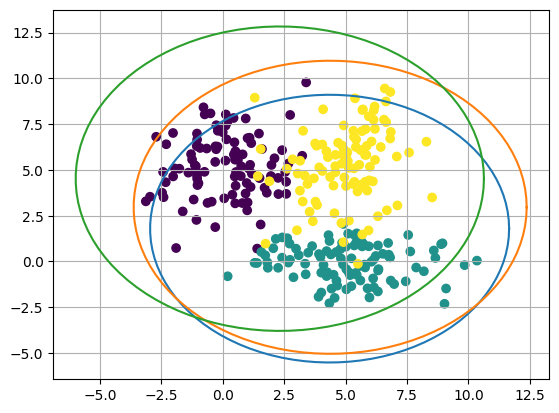

2754.33359059032
4
  
-2754.33359059032 [3.59346369 3.18979225] [[ 8.47625197 11.03438011]
 [ 8.47625197 11.03438011]] [3.61135508 3.33654909] [[8.28363965 9.43132308]
 [8.28363965 9.43132308]] [3.17321072 3.72777865] [[9.2828717 9.0165553]
 [9.2828717 9.0165553]] 3.599179056376795


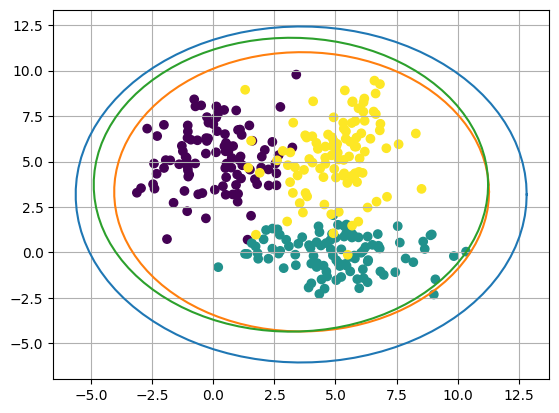

Maximum Likelihood


In [ ]:
#let's start the main function loop
#initilization
mu1 = [1,1]
sig1 = [ [1, 0], [0, 1] ]
mu2 = [4,4]
sig2 = [ [1, 0], [0, 1] ]
mu3 = [0, 5]
sig3 = [ [1, 0], [0, 1] ]
w = [0.2, 0.3, 0.5]
loglihood = logLikelihood(df.copy())
print("initial likelihood", loglihood)
dis = 10000
count = 0
track = 0
maxlikelihood = 0
while dis > 0.01:
    #E-step and M-step
    new_mu1, new_sigma1, new_weight1 = MaximizationStep(df.copy(), mu1, sig1, w[0])
    new_mu2, new_sigma2, new_weight2 = MaximizationStep(df.copy(), mu2, sig2, w[1])
    new_mu3, new_sigma3, new_weight3 = MaximizationStep(df.copy(), mu3, sig3, w[2])


    #check convergenge
    dis = params_converge([mu1, mu2, mu3], [new_mu1, new_mu2, new_mu3])
    mu1 = new_mu1
    sig1 = new_sigma1
    mu2 = new_mu2
    sig2 = new_sigma2
    mu3 = new_mu3
    sig3 = new_sigma3
    w = [new_weight1, new_weight2, new_weight3]
    #showing result pictorially

    loglihood = logLikelihood(df.copy())
    if mt.fabs(loglihood) < mt.fabs(maxlikelihood) :
        print("Maximum Likelihood")
        track = 1
        break
    maxlikelihood = loglihood
    print(mt.fabs(maxlikelihood))
    count += 1
    print(count)
    print("  ")
    print(loglihood, mu1, sig1, mu2, sig2, mu3, sig3, dis)
    u = mu1[0]
    v = mu1[1]
    a = mt.sqrt( ( mu1[0] - sig1[0][0] ) ** 2 + ( mu1[1] - sig1[0][1] ) ** 2 )
    b = mt.sqrt( ( mu1[0] - sig1[1][0] ) ** 2 + ( mu1[1] - sig1[1][1] ) ** 2 )

    t = np.linspace(0, 2 * mt.pi, 100)



    fig = plt.figure()
    plt.scatter(data['x1'], data['x2'], c=data['label'])
    plt.plot(u + a * np.cos(t), v + b * np.sin(t))
    u = mu2[0]
    v = mu2[1]
    a = mt.sqrt((mu2[0] - sig2[0][0]) ** 2 + (mu2[1] - sig2[0][1]) ** 2)
    b = mt.sqrt((mu2[0] - sig2[1][0]) ** 2 + (mu2[1] - sig2[1][1]) ** 2)

    t = np.linspace(0, 2 * mt.pi, 100)
    plt.plot(u + a * np.cos(t), v + b * np.sin(t))

    u = mu3[0]
    v = mu3[1]
    a = mt.sqrt((mu3[0] - sig3[0][0]) ** 2 + (mu3[1] - sig3[0][1]) ** 2)
    b = mt.sqrt((mu3[0] - sig3[1][0]) ** 2 + (mu3[1] - sig3[1][1]) ** 2)

    t = np.linspace(0, 2 * mt.pi, 100)
    plt.plot(u + a * np.cos(t), v + b * np.sin(t))

    #plt.grid(color='lightgray', linestyle='--')
    plt.grid()
    plt.show()
    fig.savefig("output{}.png".format(count))

if track == 0:
    print("convergence of parameters")

Loop utama algoritma EM mengulangi E-Step dan M-Step hingga konvergensi tercapai (jarak parameter yang baru dan lama < 0.01) atau log likelihood berhenti bertambah.

Kode menghentikan iterasi ketika dis, yang mengukur perubahan antara parameter model pada dua iterasi berturut-turut, lebih kecil dari 0.01. Ini menandakan bahwa parameter model sudah stabil, dan iterasi EM dapat dihentikan.

Berdasarkan deskripsi masalah, Angkatan Laut Bangladesh menggunakan sonar akustik aktif untuk mendeteksi kapal-kapal di sekitarnya. Sistem sonar menghasilkan pengukuran yang dikumpulkan dalam data 2D, yang kemudian dianalisis untuk menentukan lokasi kapal-kapal tersebut di laut.

Hasil klustering yang ditampilkan dalam gambar menunjukkan tiga kelompok yang masing-masing diwakili oleh warna yang berbeda. Setiap kelompok mewakili satu kapal yang berada di area terpisah. Garis elips di sekitar titik-titik setiap kelompok adalah batas kluster yang dihasilkan oleh model campuran Gaussian (Gaussian Mixture Model), yang menunjukkan perkiraan wilayah di mana setiap kapal mungkin berada berdasarkan pengukuran yang ada.

Analisis ini menunjukkan bahwa model campuran Gaussian telah berhasil mengelompokkan data sonar ke dalam tiga kluster, yang masing-masing menggambarkan posisi kapal secara terpisah. Dengan demikian, Angkatan Laut dapat menentukan lokasi dari setiap kapal dengan lebih baik, sehingga meningkatkan akurasi dalam penargetan jika diperlukan tindakan lebih lanjut.

initial likelihood -3418.4627415628224
2399.31451592583
1
-2399.31451592583 [ 3.26387522 -0.08351779] [[8.28978875 2.55478699]
 [8.28978875 2.55478699]] [5.47124742 3.66138368] [[4.66445751 8.5545989 ]
 [4.66445751 8.5545989 ]] [-0.04693865  5.49118487] [[1.89627958 2.44424221]
 [1.89627958 2.44424221]] 4.512943555650926


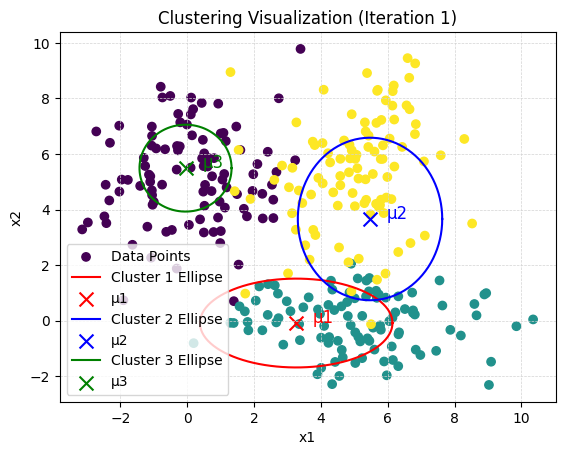

2427.0058687305896
2
-2427.0058687305896 [4.67589369 0.71506664] [[7.58901181 4.03406813]
 [7.58901181 4.03406813]] [4.85202578 3.40983231] [[ 4.73560751 10.27278581]
 [ 4.73560751 10.27278581]] [0.65395123 5.10796115] [[4.12183232 3.3086805 ]
 [4.12183232 3.3086805 ]] 3.0893824644049115


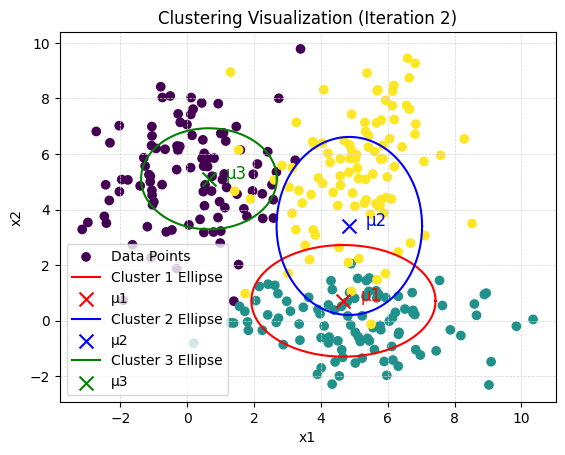

2680.3747972886977
3
-2680.3747972886977 [4.34840221 1.79487633] [[7.46051421 8.4119539 ]
 [7.46051421 8.4119539 ]] [4.3708154 2.9620093] [[ 6.5977783  10.65115974]
 [ 6.5977783  10.65115974]] [2.31978457 4.52268607] [[10.44397467  6.29621333]
 [10.44397467  6.29621333]] 3.5513869414929546


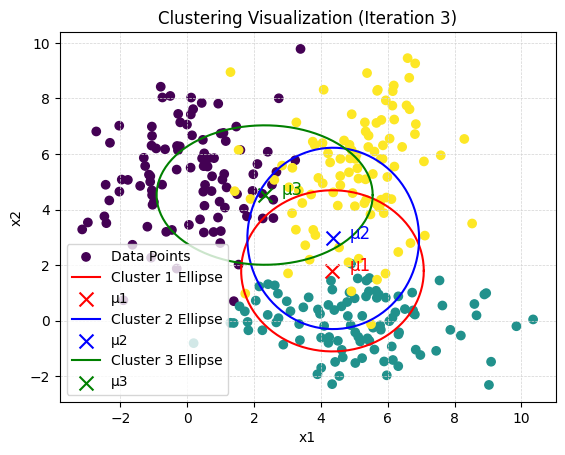

2754.33359059032
4
-2754.33359059032 [3.59346369 3.18979225] [[ 8.47625197 11.03438011]
 [ 8.47625197 11.03438011]] [3.61135508 3.33654909] [[8.28363965 9.43132308]
 [8.28363965 9.43132308]] [3.17321072 3.72777865] [[9.2828717 9.0165553]
 [9.2828717 9.0165553]] 3.599179056376795


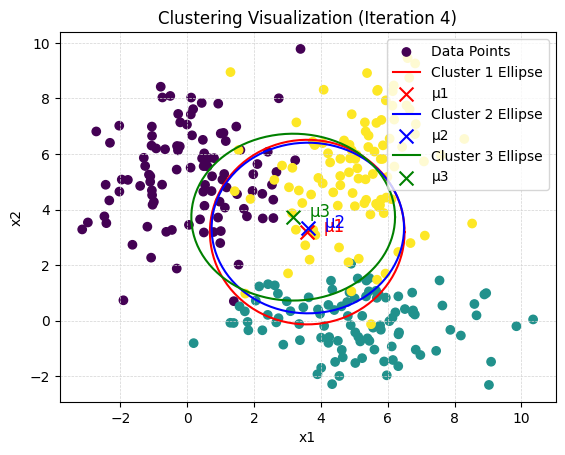

Maximum Likelihood


In [ ]:
#let's start the main function loop
#initialization
mu1 = [1, 1]
sig1 = [[1, 0], [0, 1]]
mu2 = [4, 4]
sig2 = [[1, 0], [0, 1]]
mu3 = [0, 5]
sig3 = [[1, 0], [0, 1]]
w = [0.2, 0.3, 0.5]
loglihood = logLikelihood(df.copy())
print("initial likelihood", loglihood)
dis = 10000
count = 0
track = 0
maxlikelihood = 0

while dis > 0.01:
    # E-step and M-step
    new_mu1, new_sigma1, new_weight1 = MaximizationStep(df.copy(), mu1, sig1, w[0])
    new_mu2, new_sigma2, new_weight2 = MaximizationStep(df.copy(), mu2, sig2, w[1])
    new_mu3, new_sigma3, new_weight3 = MaximizationStep(df.copy(), mu3, sig3, w[2])

    # Check convergence
    dis = params_converge([mu1, mu2, mu3], [new_mu1, new_mu2, new_mu3])
    mu1, sig1 = new_mu1, new_sigma1
    mu2, sig2 = new_mu2, new_sigma2
    mu3, sig3 = new_mu3, new_sigma3
    w = [new_weight1, new_weight2, new_weight3]

    # Log-likelihood calculation
    loglihood = logLikelihood(df.copy())
    if mt.fabs(loglihood) < mt.fabs(maxlikelihood):
        print("Maximum Likelihood")
        track = 1
        break
    maxlikelihood = loglihood
    print(mt.fabs(maxlikelihood))
    count += 1
    print(count)
    print(loglihood, mu1, sig1, mu2, sig2, mu3, sig3, dis)

    # Visualization
    fig = plt.figure()
    plt.scatter(data['x1'], data['x2'], c=data['label'], label='Data Points')

    # Ellipses for clusters
    for cluster, mu, sig, color, label in zip(
        [1, 2, 3],
        [mu1, mu2, mu3],
        [sig1, sig2, sig3],
        ['red', 'blue', 'green'],
        ['Cluster 1', 'Cluster 2', 'Cluster 3']
    ):
        u, v = mu
        a = mt.sqrt(sig[0][0])  # Standard deviation along x-axis
        b = mt.sqrt(sig[1][1])  # Standard deviation along y-axis
        t = np.linspace(0, 2 * mt.pi, 100)
        plt.plot(u + a * np.cos(t), v + b * np.sin(t), color=color, label=f'{label} Ellipse')

        # Mark cluster centers
        plt.scatter(u, v, color=color, marker='x', s=100, label=f'μ{cluster}')
        plt.text(u + 0.5, v, f'μ{cluster}', color=color, fontsize=12)

    # Add legend and grid
    plt.legend()
    plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
    plt.title(f"Clustering Visualization (Iteration {count})")
    plt.xlabel("x1")
    plt.ylabel("x2")

    plt.show()
    fig.savefig(f"output{count}.png")

if track == 0:
    print("Convergence of parameters")


Berdasarkan deskripsi masalah, Angkatan Laut Bangladesh menggunakan sonar akustik aktif untuk mendeteksi kapal-kapal di sekitarnya. Sistem sonar menghasilkan pengukuran yang dikumpulkan dalam data 2D, yang kemudian dianalisis untuk menentukan lokasi kapal-kapal tersebut di laut.

Hasil klustering yang ditampilkan dalam gambar menunjukkan tiga kelompok yang masing-masing diwakili oleh warna yang berbeda. Setiap kelompok mewakili satu kapal yang berada di area terpisah. Garis elips di sekitar titik-titik setiap kelompok adalah batas kluster yang dihasilkan oleh model campuran Gaussian (Gaussian Mixture Model), yang menunjukkan perkiraan wilayah di mana setiap kapal mungkin berada berdasarkan pengukuran yang ada.

Analisis ini menunjukkan bahwa model campuran Gaussian telah berhasil mengelompokkan data sonar ke dalam tiga kluster, yang masing-masing menggambarkan posisi kapal secara terpisah. Dengan demikian, Angkatan Laut dapat menentukan lokasi dari setiap kapal dengan lebih baik, sehingga meningkatkan akurasi dalam penargetan jika diperlukan tindakan lebih lanjut.

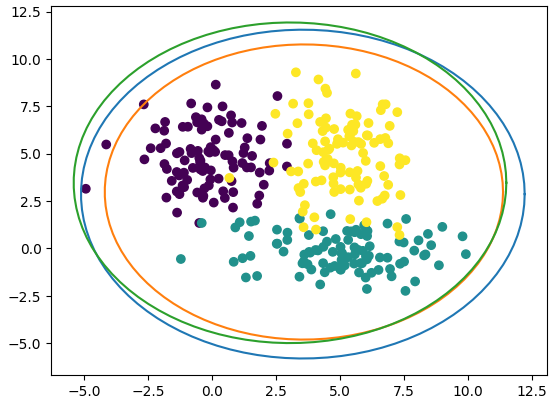

Hasil akhir clustering :

1. Titik-titik dalam setiap kelompok warna : Setiap titik mewakili hasil pengukuran dari sinyal sonar yang dipantulkan oleh kapal di permukaan air. Karena interferensi dari kapal lain atau dari noise lingkungan, pengukuran ini tersebar di sekitar posisi sebenarnya dari kapal. Namun, mereka tetap berkelompok, menunjukkan bahwa masing-masing titik dalam satu kelompok berasal dari pantulan sonar kapal yang sama.

2. Tiga kelompok warna : Ada tiga warna berbeda pada grafik (misalnya, ungu, kuning, dan hijau), yang masing-masing merepresentasikan satu kapal. Model Gaussian Mixture Model (GMM) telah mengelompokkan titik-titik pengukuran berdasarkan kedekatan spasial mereka. Dengan mengelompokkan titik-titik ini, GMM mampu mengidentifikasi bahwa data ini berasal dari tiga kapal berbeda.

3. Elips di sekitar kelompok titik-titik : Elips ini menunjukkan batas perkiraan dari kluster yang dihasilkan oleh model Gaussian. Setiap elips berpusat pada lokasi perkiraan dari kapal masing-masing, berdasarkan distribusi data dalam kluster tersebut. Elips ini menggambarkan area di mana kapal kemungkinan besar berada, dengan titik pusat elips mendekati lokasi kapal yang sebenarnya.

Jadi, secara keseluruhan, model GMM ini telah berhasil memisahkan titik-titik pengukuran sonar menjadi tiga kluster yang mewakili tiga kapal berbeda. Hasil klustering ini membantu menentukan lokasi masing-masing kapal, yang memungkinkan Angkatan Laut untuk lebih mudah mengidentifikasi dan menargetkan kapal-kapal tersebut.